# Data Diri

nama: Asis Rianto \
email: asisrianto2@gmail.com \
username: asisrianto \

---

Import The Libraries

In [1]:
import zipfile, os
import shutil
from google.colab import files
import tensorflow as tf  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Data Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#extract the dataset
local_zip = '/content/drive/MyDrive/Dataset/Flowers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
#define variable for feature and label
features = []
labels = []

for path, subdirs, files in os.walk('/content/flowers'):
  for name in files:
    features.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])

In [5]:
#split the dataset into training data and validation data
feature_train, feature_test, label_train, label_test = train_test_split(features, labels, test_size=0.20, random_state=300)

In [6]:
#create dataframe
df_training = pd.DataFrame({'features':feature_train, 'labels':label_train, 'set':'training'})
df_validation = pd.DataFrame({'features':feature_test, 'labels':label_test, 'set':'validation'})
df_dataset = df_training.append([df_validation]).reset_index(drop=1)

#check the number of training data and validation data
print('number of training data: ', len(df_training))
print('number of validation data: ', len(df_validation))

print(df_dataset.groupby(['set', 'labels']).size(), '\n')
df_dataset.sample(5)

number of training data:  3453
number of validation data:  864
set         labels   
training    daisy        608
            dandelion    849
            rose         641
            sunflower    576
            tulip        779
validation  daisy        156
            dandelion    203
            rose         143
            sunflower    157
            tulip        205
dtype: int64 



,features,labels,set
1261,/content/flowers/sunflower/14646281372_5f13794...,sunflower,training
2821,/content/flowers/dandelion/9726260379_4e8ee668...,dandelion,training
2713,/content/flowers/dandelion/16096748028_7876887...,dandelion,training
773,/content/flowers/rose/5990626258_697f007308_n.jpg,rose,training
430,/content/flowers/sunflower/6002598514_22a9a404...,sunflower,training


In [7]:
#put files into each directory

origin_dir = '/content/flowers'
destination_dir = '/dataset/'

for index, row in tq(df_dataset.iterrows(), ):

  #detect file path
  file_path = row['features']
  if os.path.exists(file_path) == False:
    file_path = os.path.join(origin_dir, row['labels'], row['image'].split('.')[0])

  #make folder destination dirs
  if os.path.exists(os.path.join(destination_dir, row['set'], row['labels'])) == False:
    os.makedirs(os.path.join(destination_dir, row['set'], row['labels']))

  #define file destination
  destination_file_name = file_path.split('/')[-1]
  file_destination = os.path.join(destination_dir, row['set'], row['labels'], destination_file_name)

  #copy file from source to dest
  if os.path.exists(file_destination) == False:
    shutil.copy(file_path, file_destination)

0it [00:00, ?it/s]

In [8]:
#check training directory
training_set = os.path.join(destination_dir, 'training')
os.listdir(training_set)

['daisy', 'tulip', 'sunflower', 'rose', 'dandelion']

In [9]:
#check validation directory
validation_set = os.path.join(destination_dir, 'validation')
os.listdir(validation_set)

['daisy', 'tulip', 'sunflower', 'rose', 'dandelion']

# Data Preprocessing

## Augmentation

In [10]:
training_datagen = ImageDataGenerator(
    rescale = 1./125,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./125,
)


In [11]:
training_generator = training_datagen.flow_from_directory(
    training_set,
    target_size = (150, 150),
    batch_size = 32,
    color_mode = "rgb",
    class_mode = 'categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_set,
    target_size = (150, 150),
    batch_size = 32,
    color_mode = "rgb",
    class_mode = 'categorical'
)

Found 3453 images belonging to 5 classes.
Found 864 images belonging to 5 classes.


# Model Selection

## Sequential

In [12]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 5, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Callbacks

In [14]:
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

# Model Training

In [15]:
EPOCHS = 50

start = time.time()
history = model.fit(training_generator,
                    epochs=EPOCHS,
                    callbacks=[model_checkpoint, early_stopping],
                    validation_data=validation_generator,
                    verbose = 1)
stop = time.time()

Epoch 1/50
108/108 [==============================] - 41s 298ms/step - loss: 1.3495 - accuracy: 0.4037 - val_loss: 1.2205 - val_accuracy: 0.4329
Epoch 2/50
108/108 [==============================] - 27s 250ms/step - loss: 1.1748 - accuracy: 0.4868 - val_loss: 1.0883 - val_accuracy: 0.5602
Epoch 3/50
108/108 [==============================] - 27s 248ms/step - loss: 1.0543 - accuracy: 0.5621 - val_loss: 0.9286 - val_accuracy: 0.6331
Epoch 4/50
108/108 [==============================] - 29s 265ms/step - loss: 0.9655 - accuracy: 0.6073 - val_loss: 0.8733 - val_accuracy: 0.6539
Epoch 5/50
108/108 [==============================] - 27s 247ms/step - loss: 0.9390 - accuracy: 0.6293 - val_loss: 0.9039 - val_accuracy: 0.6308
Epoch 6/50
108/108 [==============================] - 27s 247ms/step - loss: 0.9006 - accuracy: 0.6487 - val_loss: 0.7580 - val_accuracy: 0.7025
Epoch 7/50
108/108 [==============================] - 27s 248ms/step - loss: 0.8575 - accuracy: 0.6704 - val_loss: 0.8090 - val_ac

In [16]:
print(f'{stop-start}')

1394.8844685554504


## Visualization of Accuracy and Loss

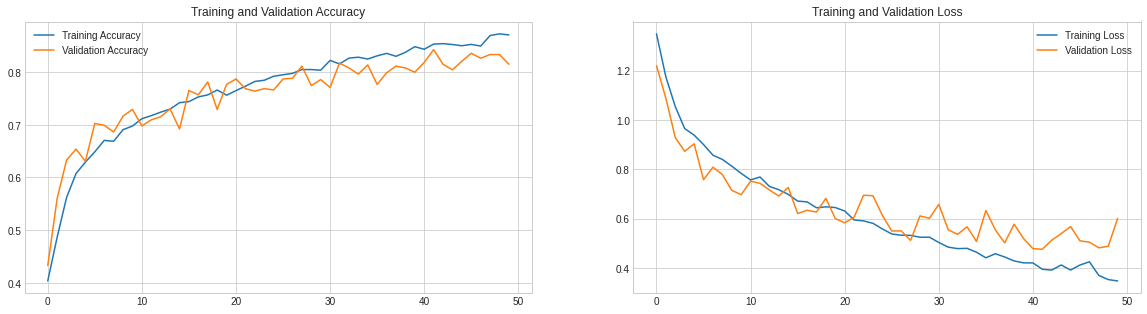

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.style.use('seaborn-whitegrid')
plt.subplots(1, 2, figsize=[20, 5])
plt.subplot(1,2,1)
acc = plt.plot(epochs, acc, label='Training Accuracy')
val_acc = plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.subplot(1,2,2)
loss = plt.plot(epochs, loss, label='Training Loss')
val_loss = plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)

plt.savefig('proposed_model.png')
plt.show()

# Save the model

In [18]:
model.save_weights("flowers_classification_weights.h5")
model.save("flowers_classification.h5")

# TF-Lite

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Classification

Saving 800px-Sunflower_sky_backdrop.webp to 800px-Sunflower_sky_backdrop.webp
1/1 [==============================] - 0s 228ms/step
Sunflower


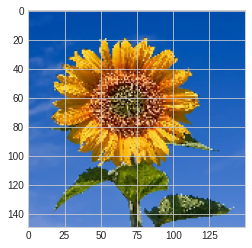

In [20]:
from google.colab import files

uploaded =  files.upload()

for fn in uploaded.keys():
    path = fn
    img = load_img(path, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img = np.vstack([x])

    label = np.argmax(model.predict(img))
    if label == 0:
      print('Daisy')
    elif label == 1:
      print('Dandelion')
    elif label == 2:
      print('Rose')
    elif label == 3:
      print('Sunflower')
    else:
      print('Tulip')